<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/gravity/AnomalySeparation_2D_SVD_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.interpolate import griddata

In [2]:
!git clone https://www.github.com/yohanesnuwara/computational-geophysics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (309/309), done.
remote: Total 548 (delta 197), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (548/548), 42.80 MiB | 25.52 MiB/s, done.
Resolving deltas: 100% (318/318), done.


Load gravity data from Roosevelt Hot Springs and display in grid map.

In [32]:
data = np.loadtxt('/content/computational-geophysics/gravity/data/Gravity_UTM.txt')
utm_x = np.array(data[:,0])
utm_y = np.array(data[:,1])
CBA = np.array(data[:,2])

In [4]:
xi = np.linspace(min(utm_x), max(utm_x), 50)
yi = np.linspace(min(utm_y), max(utm_y), 50)
xi, yi = np.meshgrid(xi, yi)

# Interpolation
zi = griddata((utm_x,utm_y),CBA,(xi,yi))

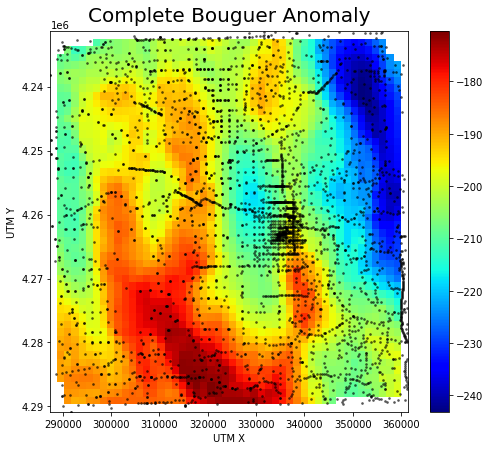

In [7]:
# Min max coordinates
xmin, xmax = min(utm_x), max(utm_x)
ymin, ymax = min(utm_y), max(utm_y)

plt.figure(figsize=(8,7))

plt.scatter(utm_x, utm_y, s=3, color='black', alpha=0.5) # Plot stations
plt.imshow(zi, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='jet')
plt.title("Complete Bouguer Anomaly", size=20, pad=10)
plt.xlabel("UTM X"); plt.ylabel("UTM Y")
plt.colorbar()

plt.show()

In [52]:
def SVD2D(xi, yi, zi):
  m, n = xi.shape

  # First derivative of g to x
  f2dx_arr = []
  for i in range (0,m-1):
    for j in range (0,n-1):
      fd=(zi[i+1][j+1]-zi[i][j])/(xi[i+1][j+1]-xi[i][j])
      f2dx_arr.append(float(fd))
  g_first_x = np.reshape(f2dx_arr, (m-1,n-1))

  # Calculate new x coordinates for g'(x)      
  x2d_arr = []
  for i in range(0,m-1):
      for j in range (0,n-1):
        xd=(xi[i+1][j+1]-xi[i][j]) * 0.5
        x2d_arr.append(float(xd))

  x_first = np.reshape(x2d_arr, (m-1,n-1))
  x_new = xi[:-1,:-1]
  x_first = x_new+x_first

  # First derivative of g to y
  f2dy_arr = []
  for i in range (0,m-1):
    for j in range (0,n-1):
      fd=(zi[i][j]-zi[i+1][j])/(yi[i][j]-yi[i+1][j])
      f2dy_arr.append(float(fd))  
  g_first_y = np.reshape(f2dy_arr, (m-1,n-1))

  # Calculate new y coordinates for g'(y)
  y2d_arr = []
  for i in range(0,m-1):
      for j in range (0,n-1):
        yd=(yi[i][j]-yi[i+1][j]) * 0.5
        y2d_arr.append(float(yd))

  y_first = np.reshape(y2d_arr, (m-1,n-1))
  y_new = yi[:-1,:-1]
  y_first = y_new+y_first

  # Total of first derivatives
  g_first = g_first_x + g_first_y

  # Second derivative of g to x
  s2dx_arr = []
  for i in range (0,m-2):
    for j in range (0,n-2):
      sd=(g_first[i+1][j+1]-g_first[i][j])/(x_first[i+1][j+1]-x_first[i][j])
      s2dx_arr.append(float(sd))
  g_second_x = np.reshape(s2dx_arr, (m-2,n-2))

  # Calculate new coordinates for g"(x)
  x2dd_arr = []
  for i in range(0,m-2):
      for j in range (0,n-2):
        xdd=(x_first[i+1][j+1]-x_first[i][j]) * 0.5
        x2dd_arr.append(float(xdd))

  x_second = np.reshape(x2dd_arr, (m-2,n-2))
  x_new = x_first[:-1,:-1]
  x_second = x_new+x_second  

  # Second derivative of g to y
  s2dy_arr = []
  for i in range (0,m-2):
    for j in range (0,n-2):
      sd=(g_first[i][j]-g_first[i+1][j])/(y_first[i][j]-y_first[i+1][j])
      s2dy_arr.append(float(sd))  
  g_second_y = np.reshape(s2dy_arr, (m-2,n-2))

  # Calculate new coordinates for g"(y)
  y2dd_arr = []
  for i in range(0,m-2):
      for j in range (0,n-2):
        ydd=(y_first[i][j]-y_first[i+1][j]) * 0.5
        y2dd_arr.append(float(ydd))

  y_second = np.reshape(y2dd_arr, (m-2,n-2))
  y_new = y_first[:-1,:-1]
  y_second = y_new+y_second  

  # Total of second derivatives
  g_second = g_second_x + g_second_y

  # Residual anomaly (-g"). Convert mgal/m2 to mgal/km2
  res = -1 * g_second * 1e6

  # Re-gridding CBA to shape (m-2,n-2) because residual has lost shape
  CBA_regrid = griddata((utm_x,utm_y),CBA,(x_second,y_second))

  # Regional. CBA minus residual
  reg = CBA_regrid - res

  return res, reg, CBA_regrid

In [38]:
# Calculate 2D Second Vertical Derivative
res, reg, CBA_regrid = SVD2D(xi, yi, zi)

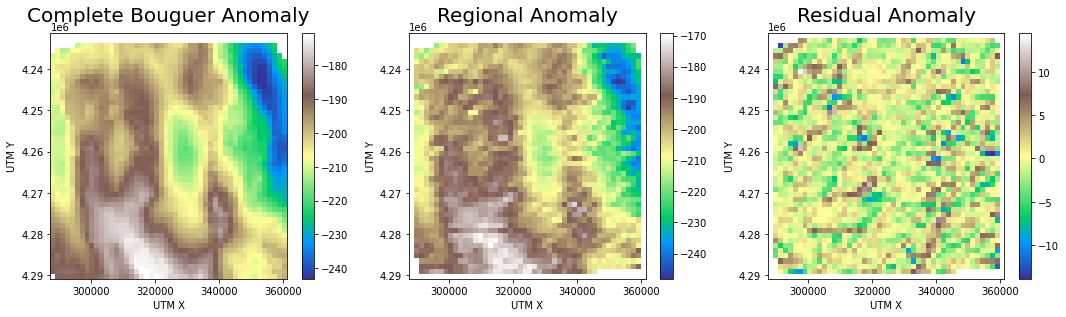

In [49]:
# Min max coordinates
xmin, xmax = min(utm_x), max(utm_x)
ymin, ymax = min(utm_y), max(utm_y)

# Grid map
plt.figure(figsize=(15,4.5))

plt.subplot(1,3,1)
plt.imshow(CBA_regrid, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Complete Bouguer Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(reg, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Regional Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(res, aspect='auto', extent=(xmin,xmax,ymax,ymin), cmap='terrain')
plt.title('Residual Anomaly', size=20, pad=12)
plt.xlabel('UTM X'); plt.ylabel('UTM Y')
plt.colorbar()

plt.tight_layout(1.03)
plt.show()